## Parallel Simulation of Barchan Sand Dune Morphology ## 

### Alexander Swart ###
#### aks13@rice.edu ####

For my Phys416 final project, I decided to see how far I could get in developing a model that simulates the response of a barchan dune to wind. 

For more information on my original project, see the project proposal [Link to Proposal](https://github.com/akswart/phys416code/blob/master/project/done/A_Swart_Proposal.pdf).

### Using FEniCS ###

An important first stage of this project involved the numerical solution of the Navier-Stokes equations to describe the airflow over a dune. We consider the incompressible Navier-Stokes equations on a domain $\Omega$ in $R^2$, consisting of a pair of momentum and continuity equations:

$u_t + \nabla u \cdot u − \nu \Delta u + \nabla p = f,$

$ \nabla \cdot u = 0, $


Here, $u$ is the unknown velocity, $p$ is the unknown pressure, $\nu$ is the kinematic viscosity, and $f$ is a given source.

I investigated several advanced CFD solvers implemented within a Python ecosystem that would also allow the effective utilization of a distributed parallel cluster. My first attempt was in using the FluidDyn open source project. In this case the mercurial repositories are publicly available in Bitbucket (https://bitbucket.org/fluiddyn/I). Unfortunately, I soon ran into problems of incompatible compiled libraries with randomly crashing front-ends that were mysteriously hard to debug. After a few hours of struggling with this I then moved to the more sophisticated open source software library FEniCS
( https://fenicsproject.org/ ). 

FEniCS is a popular open-source (LGPLv3) computing platform for solving partial differential equations. It  is an acronym with FE = finite element, and CS = computational software. The goal of FEniCS is to enable users to quickly translate scientific models into efficient finite element code. With the high-level Python and C++ interfaces to FEniCS, it is easy to get started, but FEniCS also offers powerful capabilities for more experienced programmers, since it runs on a multitude of platforms ranging from laptops to high-performance clusters.

I used a FEniCS based finite element discretization of the Navier-Stokes equations together with the automatic mesh generator to solve the parameterized flow problems.



### Solving the resulting linear system ###

After transforming the PDE + boundary conditions into a variational form, the equations give a symmetric, positive definite coefficient matrix. The FEniCS formulation we use for the Navier-Stokes equations uses a FEM formulation known as the Taylor–Hood element: P2/P1, where triangular P2 elements are used for the vector velocity field and triangular P1 elements are used for the pressure field. 

 The resulting linear system of equations are solved by a Krylov solver using a Conjugate Gradient (CG) method implemented in PETSc ( https://www.mcs.anl.gov/petsc/ ). PETSc is a powerful high-performance software library for engineering and science that recently won an R&D100 award.



### Enabling MPI implementation on a cluster###

In order for the basic code from the Fenics example to meet my requirement, I needed to make several significant modifications. 

First, since I wanted to run the code in parallel on my computer cluster, I wanted the code to be MPI compatible. Fenics has [built-in MPI support](https://www.repository.cam.ac.uk/handle/1810/245070)  that is shockingly good with minimal modifications [a simple example](https://fenicsproject.org/qa/8459/what-is-the-simplest-way-to-use-mpi/), however, the methods that they were using to write to the hdf5 and xdmf files were from a much older version of the codebase and, as a result had no MPI support. As a result, I had to change the original code, which was:


`# Save mesh to file 
File('navier_stokes_cylinder/cylinder.xml.gz') << mesh`

To a more MPI friendly alternative:

`hdf = fs.HDF5File(mesh.mpi_comm(), "navier_stokes_dune/file.h5", "w")
hdf.write(mesh, "/mesh") `



Next, they used the progress bar from DOLFIN, which, according to several forum posts (https://fenicsproject.discourse.group/t/how-to-update-the-progress-bar-in-fenics/90) was never really a great option. Instead, I decreased the Fenics logging parameters to only log important warnings and errors with fs.set_log_level(fs.LogLevel.ERROR) and used a fantastic progress bar, tdqm (https://github.com/tqdm/tqdm), which was highly recommended by a user from the fenics forums. In comparison to the native Python ProgressBar (https://github.com/niltonvolpato/python-progressbar), tdqm has an order of magnitude less overhead at around 60 ns per iteration (according to their github page.)

Finally, I wrote quite a bit of code that was super helpful in keeping the separate runs organized and archived. I was getting hdf5 write errors when writing over a file that already existed, and I had already struggled quite a bit with getting my hdf5 files written in the proper format (so that Paraview, my visualization software could read it.) As a result, I wrote quite a lot of cross-platform compatible code that would compress the previous run, uniquely timestamp it, and then move it to an archive folder. In retrospect, if it was just me running this code, I wouldn't have bothered with Windows compatibility, but at the time I was seriously having trouble getting the right environments setup across both my Windows and Ubuntu systems, so I wanted the option to easily move between platforms. All this code can be found in the try-except statments at the beginning of navier_stokes_dune.py

However, I needed to make more than superficial modifications in order to run a fluid simulation over the surface of a dune.

### Mesh generation ###

First, it was necessary to develop a custom grid mesh to model a channel while excluding the dune from the grid. This was done by creating a gaussian mesh from a discretized gaussian function. Next, since we essentially want the inverse problem, we leveraged the constructive solid geometry (CSG) abilities of Fenics' mesh generation and subtracted the gaussian mesh from a rectangular mesh. The hard part of this was getting the balance between the gaussian discretization and the rectangular mesh size. I found that if the mesh for the gaussian was too small, the CSG would assign the dune to be surrounded by a small mesh, in comparison to the regular rectangular mesh. This, in addition to slight discontinuities in the initial version of my mesh generator, caused the preconditioners to fail to converge, and as a result, the method would fail. However, after smoothing out the interfaces between the gaussian and the rectangular mesh and balancing the gaussian discretization with the rectangular grid size, this issue was solved for the same range of step sizes as in the original example code.

Here is an example mesh that I used:

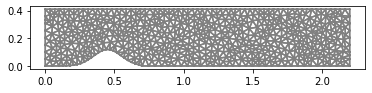

In [2]:
from fenics import *
from mshr import *
from dune_mesh import generate_dune_mesh #My function to make the mesh

dune_mesh = generate_dune_mesh(True,32) # Make a mesh with 32 grid points in either direction
plot(dune_mesh) #Plot the mesh


### Boundary and Initial Conditions###

In addition, I needed to change the boundary conditions to account for a dune on the bottom of the region, instead of just a flat bottom.

 `   dune = 'near(x[1], 0) || on_boundary && x[0]>.02 && x[0]<2 && x[1]>=0 && x[1]<.3'`

This line of code tells Fenics to assign boundary conditions for bottom of the region, so, either where y=0 (no dune) or wherever there is a mesh boundary inside a predefined region where I put the dune. Then, we assign no-slip boundary conditions with:

`bcu_dune = fs.DirichletBC(V, fs.Constant((0, 0)), dune)`


### Benchmarking on a cluster ###

Finally, I ran navier_stokes_channel_benchmark.py. This is similar to navier_stokes_dune.py, but just simulates laminar flow in a channel. I did this in order to get a good idea of what the relationships between grid size, accuracy, and run time was. This code was very similar to the code from the first part of the Fenics Poisson solving example, however, I have also modified it to compare results to a ground truth, and the benchmark for dozens of different grid sizes in parallel (using Python's native multiprocessing module.)

Here are some relevant graphs:

In [11]:
import numpy as np
import matplotlib.pyplot as plt

benchmark_data = np.load("benchmarkout.npz") # Benchmarking data import from previous server overnight run

In [12]:
grid_sizes = benchmark_data['arr_0']
bench_times = benchmark_data["arr_1"]/10 # Divide by 10 since we take 10 runs in timeit
error_arrays = benchmark_data['arr_2']
time_arrays = benchmark_data["arr_3"]

Text(0, 0.5, 'Time to run navier() in seconds')

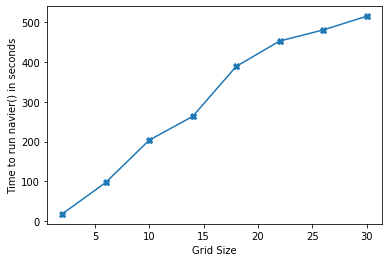

In [13]:
# Plot grid size vs average compute time
plt.plot(grid_sizes,bench_times,marker='X')
plt.xlabel("Grid Size")
plt.ylabel("Time to run navier() in seconds") #Navier() is in navier_stokes_benchmark.py

The above result implies that our alogrithm scales linearly with the number of grid points. Additionally note that the 32 grid size runs took about 10 min each. Most of the runs shown later from navier_stokes_dune.py took 30-90 min with a grid size of 64.

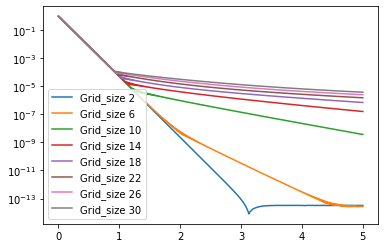

In [22]:
len(grid_sizes)

for i in range(len(grid_sizes)):
    g = grid_sizes[i]
    e = error_arrays[i]
    t = time_arrays[i]
    
    plt.semilogy(t,e) # Plot the error as time progresses for each grid size
plt.legend([f"Grid_size {i}" for i in grid_sizes  ])

The above results show the limit of the approximiation error on a sequence of overly underresolving meshes

### Airflow over a dune ###

Finally, I ran navier_stokes_dune.py for a variety of different flow conditions of wind over a dune. Here are the output animations of the flow velocity. Despite my code being multithreaded, in order to get a nice smooth animation, I had to run at or above a grid_size=64, often resulting in hour-long run times for 5000 time steps, even on my server with 48 cores and 384 GiB of RAM.


In order to make the animations, I loaded the velocity.xdmf files into Paraview, and used "XDMF Reader" to read them in. This step actually gave me quite a bit of trouble, as it turns out writing to the files inside Spyder was producing corrupted xdmf and/or hdf5 files. If you run into issues here, I would strongly recommend just running it from the command line.

The animations are of the fluid velocity.

Here is a youtube video of a run of navier_stokes_dune.py
Its done with a end time (T) of 5, 10^4 timesteps, a grid size of 64, and Linear flow with velocity 1

[Video](https://youtu.be/4ed6HijhW68)

This run is done with T=5, 10^4 timesteps, grid size of 64, and Linear flow with velocity 1.5

[Video](https://youtu.be/JzJqJ9JFEKg)

I wanted to push the velocity higher and see what happens when I get non-linear flow, but unfortunately, it keps crashing my proconditioner, since the velocity blows up when the CFL number is too high or the Reynolds number of some grid cell is too high [Source](https://fenicsproject.org/qa/4295/error-unable-solve-linear-system-using-petsc-krylov-solver/)

This run is done with T=10, 10^4 timesteps, grid size of 96, and non linear flow with profile [Link](https://i.imgur.com/FaNc6YO.png)

[Video](https://youtu.be/IHgc9pslA1U)

Unsurprisingly enough, we see smooth flow over the dune in all cases. In the future, I would like to further refine either the numerical methods used or the running parameters so that turbulent flow will be observed at higher flow speeds.

Furthermore, there is much more that needs to be done to complete this model, namely modeling sand transport and extending it to 3D.